In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import time
import os
import sys
import json

import scipy as sp
from scipy import signal

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from keras.callbacks import EarlyStopping
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import os, warnings, random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers, Sequential, Model
from tensorflow.keras.callbacks import LearningRateScheduler

In [2]:
SEED = 13
tf.random.set_seed(SEED)

In [3]:
def encode_gait_percentage(df, name):
  percent = df[name].values.tolist()
  X = np.zeros((len(df[name]),1))
  Y = np.zeros((len(df[name]),1))
  for i in range (len(percent)):
    phi = percent[i] * 2 * math.pi / 100
    X[i] = math.cos(phi)
    Y[i] = math.sin(phi)
  df['X'] = X
  df['Y'] = Y

In [4]:
def convert_data(d_x, d_y, look_back = 1, fore_cast = 1):
    dataX = []
    dataY = []

    for i in range(look_back, len(d_x) - fore_cast):
        dataX.append(d_x[i - look_back: i])
        dataY.append(d_y[i + fore_cast,:])

    return np.array(dataX), np.array(dataY)

In [5]:
working_dir = os.getcwd()#os.path.dirname(os.getcwd())
sys_platform = sys.platform
excel_path_dict = {'linux' : "/csvs/", 'win32' : "\Data\Incline\\right_based\\"}
excel_path_name = excel_path_dict[sys_platform]

directory_path = working_dir 
print(directory_path)
excel_path = directory_path + excel_path_name

c:\Users\Admin\Desktop\Neurorobotic Lab\Data_Code\Model\Gait_Phase_Prediction


In [6]:
sub1_file = ['TH\TH_I_0.xlsx', 'TH\TH_I_2.xlsx', 'TH\TH_I_3.xlsx', 'TH\TH_I_4.xlsx', 'TH\TH_I_5.xlsx' ]
sub2_file = ['JL\JL_I_0.xlsx', 'JL\JL_I_2.xlsx', 'JL\JL_I_3.xlsx', 'JL\JL_I_4.xlsx', 'JL\JL_I_5.xlsx' ]
sub3_file = ['SD\SD_1_I.xlsx', 'SD\SD_2_I.xlsx', 'SD\SD_3_I.xlsx', 'SD\SD_4_I.xlsx', 'SD\SD_5_I.xlsx']
sub4_file = ['PK\PK_0_I.xlsx', 'PK\PK_5_I.xlsx', 'PK\PK_2_I.xlsx', 'PK\PK_3_I.xlsx']
sub5_file = ['SKS\SKS_0_I.xlsx', 'SKS\SKS_4_I.xlsx', 'SKS\SKS_2_I.xlsx', 'SKS\SKS_3_I.xlsx', 'SKS\SKS_5_I.xlsx']
sub6_file = ['SOE\SOE_I_0.xlsx', 'SOE\SOE_I_2.xlsx', 'SOE\SOE_I_3.xlsx', 'SOE\SOE_I_4.xlsx', 'SOE\SOE_I_5.xlsx']
sub7_file = ['VP\VP_I_0.xlsx', 'VP\VP_I_2.xlsx', 'VP\VP_I_3.xlsx', 'VP\VP_I_5.xlsx']

file_name = sub7_file

subject = file_name[0].split('\\')[0]

subject_dict = {'SKS':[0.73, 0.58],'VP':[0.95, 0.77],'SOE':[0.88, 0.83],'SD':[0.75, 0.70], 'TH':[0.57, 0.52], 'PK':[0.72, 0.88]}

file_list=[]

for i in range (len(file_name)):
    file_list.append(pd.read_excel(excel_path + file_name[i], sheet_name='Sheet1'))
    leg_len = subject_dict[subject][0]
    weight = subject_dict[subject][1]

import random
random.shuffle(file_list)

all_data = pd.concat(file_list, axis=0, ignore_index=True)

In [7]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193557 entries, 0 to 193556
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   n_lcop        193557 non-null  int64  
 1   n_rcop        193557 non-null  int64  
 2   l_ph_ank      193557 non-null  float64
 3   l_ph_hip      193557 non-null  float64
 4   l_ph_fo       193557 non-null  float64
 5   r_ph_ank      193557 non-null  float64
 6   r_ph_hip      193557 non-null  float64
 7   r_ph_fo       193557 non-null  float64
 8   n_lgrf        193557 non-null  float64
 9   n_r_grf       193557 non-null  float64
 10  st_sw_phase   193557 non-null  int64  
 11  perc_new      193557 non-null  float64
 12  strike_frame  193557 non-null  int64  
dtypes: float64(9), int64(4)
memory usage: 19.2 MB


In [8]:
cycle = 0
cycle_list = []

start = 0

for i in range(len(all_data) - 1):
    if (all_data['perc_new'][i+1] == 0):
        cycle += 1
        cycle_list.append(all_data.iloc[start:i])
        start = i+1

random.shuffle(cycle_list)
source_table = pd.concat(cycle_list, axis=0, ignore_index=True)

source_table

,n_lcop,n_rcop,l_ph_ank,l_ph_hip,l_ph_fo,r_ph_ank,r_ph_hip,r_ph_fo,n_lgrf,n_r_grf,st_sw_phase,perc_new,strike_frame
0,0,0,0.0,352.868773,0.213524,1.367084e-10,302.061557,330.154899,0.067526,2.761744,0,0.000000,1
1,0,0,0.0,352.604034,0.828170,9.066525e-11,290.958367,331.263613,0.130385,2.747346,0,0.434783,2
2,0,0,0.0,352.245024,1.455440,5.144329e-11,285.082357,332.646028,0.212924,2.731688,0,0.869565,3
3,0,0,0.0,351.773942,2.086309,1.858780e-11,281.452730,334.339701,0.316580,2.714555,0,1.304348,4
4,0,0,0.0,351.172113,2.711508,3.600000e+02,278.958733,336.383835,0.440915,2.695530,0,1.739130,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
192532,0,0,0.0,357.727644,356.917883,0.000000e+00,74.232322,329.006470,0.000000,2.684435,0,97.424893,228
192533,0,0,0.0,358.246631,357.442884,0.000000e+00,69.211378,329.025765,0.000000,2.683016,0,97.854077,229
192534,0,0,0.0,358.687917,358.025131,0.000000e+00,60.367641,329.201303,0.000000,2.681219,0,98.283262,230
192535,0,0,0.0,359.029887,358.657255,0.000000e+00,41.783812,329.552354,0.000000,2.679192,0,98.712446,231


In [9]:
drop_list = ["n_lgrf","n_r_grf","l_ph_ank","r_ph_ank"]

In [10]:
source_table = source_table.drop(drop_list, axis = 1)
source_table

,n_lcop,n_rcop,l_ph_hip,l_ph_fo,r_ph_hip,r_ph_fo,st_sw_phase,perc_new,strike_frame
0,0,0,352.868773,0.213524,302.061557,330.154899,0,0.000000,1
1,0,0,352.604034,0.828170,290.958367,331.263613,0,0.434783,2
2,0,0,352.245024,1.455440,285.082357,332.646028,0,0.869565,3
3,0,0,351.773942,2.086309,281.452730,334.339701,0,1.304348,4
4,0,0,351.172113,2.711508,278.958733,336.383835,0,1.739130,5
...,...,...,...,...,...,...,...,...,...
192532,0,0,357.727644,356.917883,74.232322,329.006470,0,97.424893,228
192533,0,0,358.246631,357.442884,69.211378,329.025765,0,97.854077,229
192534,0,0,358.687917,358.025131,60.367641,329.201303,0,98.283262,230
192535,0,0,359.029887,358.657255,41.783812,329.552354,0,98.712446,231


In [11]:
x = source_table
x = x.drop(['perc_new'], axis=1)

column_name = x.columns

scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled, columns = column_name)

strike_index = x_scaled.columns.tolist().index('strike_frame')
print(strike_index)

x_scaled['leg_len'] = leg_len
x_scaled['weight'] = weight

encode_gait_percentage(source_table, 'perc_new')
y = source_table[["X","Y"]]
y

data_x = x_scaled

7


In [12]:
data_x

,n_lcop,n_rcop,l_ph_hip,l_ph_fo,r_ph_hip,r_ph_fo,st_sw_phase,strike_frame,leg_len,weight
0,0.0,0.0,0.980197,0.000593,0.839063,0.917098,0.0,0.000000,0.95,0.77
1,0.0,0.0,0.979461,0.002300,0.808221,0.920178,0.0,0.003289,0.95,0.77
2,0.0,0.0,0.978464,0.004043,0.791899,0.924018,0.0,0.006579,0.95,0.77
3,0.0,0.0,0.977156,0.005795,0.781816,0.928723,0.0,0.009868,0.95,0.77
4,0.0,0.0,0.975484,0.007532,0.774888,0.934401,0.0,0.013158,0.95,0.77
...,...,...,...,...,...,...,...,...,...,...
192532,0.0,0.0,0.993694,0.991439,0.206200,0.913908,0.0,0.746711,0.95,0.77
192533,0.0,0.0,0.995135,0.992897,0.192253,0.913962,0.0,0.750000,0.95,0.77
192534,0.0,0.0,0.996361,0.994515,0.167687,0.914449,0.0,0.753289,0.95,0.77
192535,0.0,0.0,0.997311,0.996271,0.116064,0.915424,0.0,0.756579,0.95,0.77


In [13]:
data_y = y.values.reshape(-1,2)

In [14]:

#data_x,data_y= shuffle_multiple_datasets_based_on_gait_cycle( file_name, excel_path)

X_train, X_test,y_train, y_test = train_test_split(data_x, data_y ,
                        test_size=0.25,
                        shuffle=False)
look_back = 10
fore_cast = 1

train_x, train_y = convert_data(X_train, y_train, look_back, fore_cast)
validation_x, validation_y = convert_data(X_test, y_test, look_back, fore_cast)


In [15]:
print(train_x.shape)
print(train_y.shape)
print(validation_x.shape)
print(validation_y.shape)

(144391, 10, 10)
(144391, 2)
(48124, 10, 10)
(48124, 2)


In [16]:
from keras import Model
from keras.layers import Layer
import keras.backend as K
import keras
from keras.layers import Input, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        print(x.shape)
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [17]:
class Sampling(L.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        seq = tf.shape(z_mean)[1]
        dim = tf.shape(z_mean)[2]
        epsilon = tf.random.normal(shape=(batch, seq, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [18]:
def encoder_model():

  x=Input(shape=(seq_len, train_x.shape[2]))
  part_1 = x[:, :, :(train_x.shape[2] - 2)]

  part_2 = x[:, :, (train_x.shape[2] - 2):]
  print(part_2)
  l1=tf.keras.layers.AveragePooling1D(
      pool_size=2,
      strides=1, padding="same")(part_1)
  att1 = attention()(part_1)
  rep_layer = L.RepeatVector((seq_len))(att1)
  # latent_sp=L.TimeDistributed(Dense(4))(rep_layer)
  f1=tf.keras.layers.Flatten()(l1)
  print(l1.shape)
  lstm_inp=L.Concatenate(axis=2)([l1,rep_layer, part_2])
  # RNN_layer = SimpleRNN(hidden_units, return_sequences=True, activation=activation)(x)
  LSTM_layer2 = LSTM(32, return_sequences=True)(lstm_inp)
  # attn_layer1 = attention()(LSTM_layer2)
  mean = L.Dense(3)(LSTM_layer2)
  log_var= L.Dense(3)(LSTM_layer2)
  z = Sampling()([mean, log_var])
  latent_sp=L.TimeDistributed(L.Dense(3))(LSTM_layer2)

  encoder = tf.keras.Model(x, (mean, log_var, z, latent_sp), name="Encoder")
  return encoder

In [19]:
def decoder_model():

  latent_dim =(10,8)
  n_real_features = n_features -2
  input_1_shape=(10,3)
  input_2_shape=( 10,3)
  input_3_shape=( 10,2)
  input1 = tf.keras.Input(shape=input_1_shape, name='input_layer1')
  input2 = tf.keras.Input(shape=input_2_shape, name='input_layer2')
  concat1= L.Concatenate(axis=2)
  concatenated_input = L.Concatenate(axis=2)([input1, input2])
  # pooled_l = L.AveragePooling2D(pool_size=)
  # f=Flatten()(concatenated_input)
  # print(f)
  dec_l1 = L.Dense(8)(concatenated_input)
  # rep_layer = L.RepeatVector((seq_len))(dec_l1);
  dec_LSTM_layer1 = LSTM(32, return_sequences=True)(dec_l1)
  dec_LSTM_layer2 = LSTM(8, return_sequences=True)(dec_LSTM_layer1)

  lin_layer = L.TimeDistributed(L.Dense(n_real_features))(dec_LSTM_layer2)

  # tmp_layer = Flatten()(dec_LSTM_layer)
  # lin_layer = L.Dense(2)(tmp_layer)
  decoder = tf.keras.Model([input1, input2], lin_layer, name="Decoder")
  return decoder


In [20]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z, ls = self.encoder(data)
            # inp_dec = tf.concat((z, ls, p2), axis=2)
            # print(inp_dec)
            reconstruction = self.decoder([z,ls])
            # tmp1=keras.losses.binary_crossentropy(data, reconstruction)
            # reconstruction_loss = K.mean(K.square(data - reconstruction))
            mse = tf.keras.losses.MeanSquaredError()
            real_data = data[:,:,0:train_x.shape[2]-2]
            reconstruction_loss = mse(real_data, reconstruction)
            # reconstruction_loss = tf.reduce_mean(
            #     tf.reduce_sum(
            #         keras.losses.binary_crossentropy(data, reconstruction)
            #     )
            # )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=(1,2)))
            total_loss = 1.5*reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [21]:
def train_vae(train_x):
  enc=encoder_model()
  dec=decoder_model()
  vae = VAE(enc, dec)
  vae.compile(optimizer=keras.optimizers.Adam())
  vae.fit(train_x, epochs=20, batch_size=64)

  return vae.encoder,vae.decoder

In [22]:
def create_latent_space_train_mlp(encoder, train_x):
  _,_,samp_t, ls_t=encoder.predict(train_x)
  ls_t = tf.concat((samp_t, ls_t), axis=2)
  print('Encoded time-series shape', ls_t.shape)
  return ls_t

In [23]:
seq_len = train_x.shape[1]
n_features = train_x.shape[2]
#encoder_model().summary()
#decoder_model().summary()

from tensorflow import keras

In [24]:

def train_mlp_model(samp_t, train_y):
  mlp_model = Sequential()

  mlp_model.add(tf.keras.Input(shape=(samp_t.shape[1], samp_t.shape[2]), name='input_layer'))
  mlp_model.add(LSTM(32))

  mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu'))
# mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu', input_dim=(samp_t.shape[1]*samp_t.shape[2])))
# mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu', input_dim=(train_encoded.shape[1])))

  mlp_model.add(L.Dense(8, kernel_initializer='glorot_normal', activation='relu'))
  mlp_model.add(L.Dense(2))
  mlp_model.summary()

  initial_learning_rate = 0.001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
  adam = optimizers.Adam(lr_schedule)

  mlp_model.compile(loss='mse', optimizer=adam)

  epochs = 25
  batch=64
  # lrate = LearningRateScheduler(step_decay)
  monitor = EarlyStopping(monitor='loss', min_delta=1e-5, patience=3, verbose=1, mode='auto')
  # train_encoded_reshaped=np.reshape(train_encoded,(train_encoded.shape[0], train_encoded.shape[1]*train_encoded.shape[2]))

  # train_encoded_reshaped=np.reshape(train_encoded,(train_encoded.shape[0], train_encoded.shape[1]))
  # train_encoded_reshaped = train_encoded
  callback_list = [monitor]
  mlp_history = mlp_model.fit(samp_t , train_y, callbacks=callback_list, epochs=epochs, batch_size=batch,  verbose=1)

  return mlp_model
# lrate = LearningRateScheduler(step_decay)

In [25]:
encoder, decoder = train_vae(train_x)
samp_t = create_latent_space_train_mlp(encoder, train_x)
mlp_model = train_mlp_model(samp_t, train_y)

KerasTensor(type_spec=TensorSpec(shape=(None, 10, 2), dtype=tf.float32, name=None), name='tf.__operators__.getitem_1/strided_slice:0', description="created by layer 'tf.__operators__.getitem_1'")
(None, 10, 8)
(None, 10, 8)
Epoch 1/20
(None, 10, 8)
(None, 10, 8)
2257/2257 [==============================] - 24s 9ms/step - loss: 0.0941 - reconstruction_loss: 0.0221 - kl_loss: 0.0039
Epoch 2/20
2257/2257 [==============================] - 21s 9ms/step - loss: 0.0055 - reconstruction_loss: 0.0027 - kl_loss: 9.7035e-05
Epoch 3/20
2257/2257 [==============================] - 21s 9ms/step - loss: 0.0021 - reconstruction_loss: 0.0012 - kl_loss: 4.1640e-05
Epoch 4/20
2257/2257 [==============================] - 21s 9ms/step - loss: 0.0014 - reconstruction_loss: 8.5488e-04 - kl_loss: 3.0940e-05
Epoch 5/20
2257/2257 [==============================] - 21s 9ms/step - loss: 0.0011 - reconstruction_loss: 6.5252e-04 - kl_loss: 2.4470e-05
Epoch 6/20
2257/2257 [==============================] - 21s 9ms/

In [26]:
_,_,samp_v, ls_v=encoder.predict(validation_x)
ls_v = tf.concat((samp_v, ls_v), axis=2)

print('Encoded time-series shape', ls_v.shape)

testPredict = mlp_model.predict(ls_v)

print(validation_y.shape)
print(testPredict.shape)

1504/1504 [==============================] - 3s 2ms/step
Encoded time-series shape (48124, 10, 6)
1504/1504 [==============================] - 3s 2ms/step
(48124, 2)
(48124, 2)


In [27]:
from sklearn.metrics import mean_squared_error


testScore = np.sqrt(mean_squared_error(validation_y, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 0.08 RMSE


In [28]:
v = X_test[11:]
v.shape

(48124, 10)

In [29]:
v=v.iloc[:, :train_x.shape[2]-2]

In [30]:
x_test = scaler.inverse_transform(v)

In [31]:
pred = np.zeros((len(testPredict),1))

for iter in range(len(testPredict)):
  x = testPredict[iter][0]
  y = testPredict[iter][1]
  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))


  if ((pred[iter] >= 80) & (x_test[iter][strike_index] <= 20)) :
    pred[iter] = pred[iter] - 100
    
    if abs(pred[iter]) >= 5:
        pred[iter] = 0


  if ((pred[iter] <= 20) & (x_test[iter][strike_index] >= 150)):
     pred[iter] = 100 - pred[iter]
     if abs(pred[iter]) >= 5:
         pred[iter] = 100



In [32]:
actual = np.zeros((len(validation_y),1))

for iter in range(len(validation_y)):
  x =validation_y[iter][0]
  y =validation_y[iter][1]
  actual[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

In [33]:
correct = 0
for i in range(5):
  correct = 0
  for iter in range(len(actual)):
    #if (abs(actual[iter] - pred[iter]) <= (i+1)) or (actual[iter]>98) or(actual[iter]<3):
      #correct+=1
      if (abs(actual[iter] - pred[iter]) <= (i+1)):
        correct+=1

  print(correct)
  print(len(actual))

  print("Precision ", i+1, ": ", correct * 100/len(actual))

26174
48124
Precision  1 :  54.38866262156097
38704
48124
Precision  2 :  80.425567284515
43987
48124
Precision  3 :  91.40345773418669
46408
48124
Precision  4 :  96.43421161998171
47470
48124
Precision  5 :  98.64101072230072


In [34]:
perc_rmse = np.sqrt(mean_squared_error(actual, pred))
print("Predicting Percentage RMSE: ", perc_rmse)



Predicting Percentage RMSE:  1.7183971203055324


In [35]:
rmse = 0
length = len(actual)
for i in range(len(actual)):

    rmse = rmse + pow(pred[i] - actual[i], 2)
rmse = rmse / length
rmse = math.sqrt(rmse)
print(length)
print(len(actual))
print(rmse)

48124
48124
1.718397120305537


26833
48124


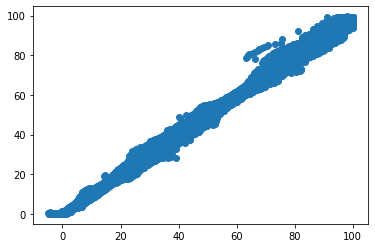

In [36]:
correct = 0

plt.figure()
plt.scatter(pred, actual)
for iter in range(len(actual)):
  if actual[iter]<2 or actual[iter]>98:
    correct+=1
    continue
  if (abs(actual[iter] - pred[iter]) <= 1):
    correct+=1


print(correct)
print(len(actual))

In [37]:
perc_rmse = np.sqrt(mean_squared_error(actual, pred))
print("Predicting Percentage RMSE: ", perc_rmse)

Predicting Percentage RMSE:  1.7183971203055324


Text(0.5, 1.0, 'Actual vs Prediction')

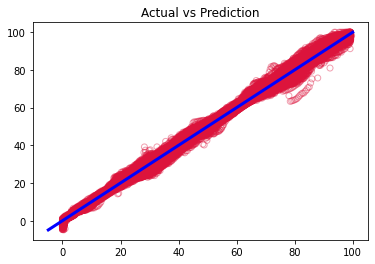

In [38]:
plt.scatter(actual, pred, facecolors='none', edgecolors='crimson',alpha=0.4)
p1 = max(max(pred), max(actual))
p2 = min(min(pred), min(actual))

ci = 0.1 * np.std([p1,p2]) / np.mean([p1,p2])

plt.plot([p1, p2], [p1, p2], 'b-', linewidth =3)
plt.title('Actual vs Prediction')